# TinyML Lab: Activity Recognition


Goals:

1. Download the dataset and visualize the accelerometer signals
2. Train and test a Tensorflow classifier on the data given
3. Convert the model to TFLite format and make it ready for deploying on device.
4. Setup Arduino board and view accelerometer signals live from it.
5. Deploy the model on the Arduino board
6. Test the model prediction on the go: when you do the movements yourself!

**There are multiple food for thought points to explore beyond this lab excercise.**

Personal Notes:
400 entries per gesture

# **<font color="red"> Steps before you continue </font>**

1. Copy the colab in your own account (Goto "File" of this colab and click "Save a copy in Drive") and continue to work on the copied version.
2. Download the datasets (and other datasets and code that we'll need later) from [here](https://drive.google.com/drive/folders/1tHONz7qgeFB87TVK2b-A18dbe8WRgV0g?usp=sharing) and upload them to sample_data folder on the left sidebar>Files tab. If you disconnect from the colab (e.g., close the tab or do not use it for a long time) then the files need to be uploaded again.

# What if
1. I have never used python before.
> If you have used C/C++/Java or other languages understanding the syntax won't be a lot of problem. Please carry on. Consult online resources as needed.
2. I have never coded a machine learning model.
> This is one of the purposes to make you practically familiar with machine learning. Pay special attention to the Tensorflow training section. Follow the optional questions for more.
3. I do not know what is machine learning.
> We covered it briefly in Week 8 lecture. Please review the lecture slides, the lab doesn't need anything more than that to start.

You may become excited about different aspects of this excercise. Please take a look at the end of the colab for more ideas to explore even as part of your final dissertation.

## Dataset description

The three files (punch.csv, wave.csv, idle.csv) are contain accelerometer data collected in the following way:



```
Punch (👊): hold the Arduino board in the hand and do punching motion (repeatedly). The csv file contains around 70 punches.

Wave (👋): hold the Arduino board in the hand and wave the hand. The csv file has around 70 waves.

Idle: The board is left idle on the table.
```

The accelerometer works with 119 Hz sampling rate. Above three files have similar amount of data, thus the dataset is balanced.



# Visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print(f"TensorFlow version = {tf.__version__}\n")

TensorFlow version = 2.18.0



      x     y     z
0 -0.95  0.30 -0.15
1 -0.95  0.31 -0.15
2 -0.95  0.30 -0.15
3 -0.95  0.29 -0.15
4 -0.95  0.29 -0.15


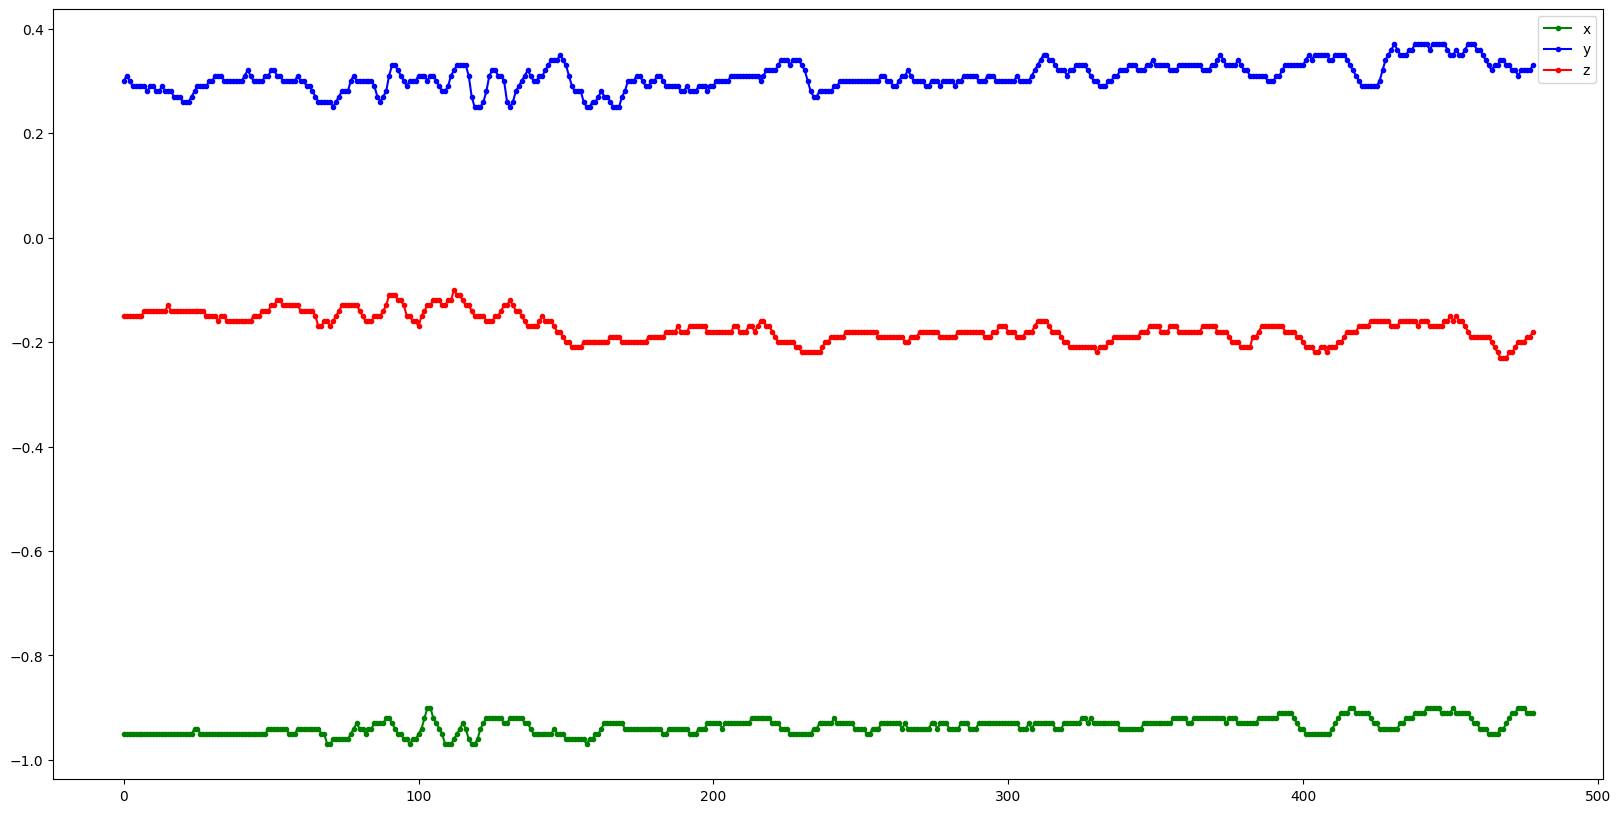

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data with Correct Delimiter
df = pd.read_csv("/content/topPos.csv", delimiter=',')  # Use ',' instead of '\t'
df.columns = df.columns.str.strip()  # Remove any spaces

# Debug Print
print(df.head())  # Ensure x, y, z columns are separate

# Plot Function
def plot_ts(df, ax=None, ls='-'):
    num = 479
    index = np.arange(0, len(df['x']) + 1)
    ax.plot(index[:num], df['x'].values[:num], 'g.', label='x', linestyle=ls)
    ax.plot(index[:num], df['y'].values[:num], 'b.', label='y', linestyle=ls)
    ax.plot(index[:num], df['z'].values[:num], 'r.', label='z', linestyle=ls)

# Plot
fig, ax = plt.subplots(figsize=(20, 10))
plot_ts(df, ax, ls='-')

plt.legend()
plt.show()


## Optional excercise

Do a [Short Term Fourier Transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html) of the signal. Visualize them for the two classes. Can you see a difference now? Similar techniques are used in ML pipelines where the signal is first converted to [MFCC](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum#:~:text=Mel%2Dfrequency%20cepstral%20coefficients%20(MFCCs,%2Da%2Dspectrum%22).) coefficients or STFT and then fed to deep learning / ML models.

# Tensorflow Training

In [ ]:
import tensorflow as tf
print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

TensorFlow version = 2.18.0



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Set a fixed random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# List of gestures
GESTURES = ["rest", "bicep_in_lab","topPos","other_but_still"]

SAMPLES_PER_GESTURE = 50
NUM_GESTURES = len(GESTURES)

# Store inputs and outputs
inputs = []
outputs = []

# Read each CSV file and prepare input/output data
for gesture_index, gesture in enumerate(GESTURES):
    print(f"Processing index {gesture_index} for gesture '{gesture}'.")

    # Load data with the correct delimiter
    file_path = f"/content/{gesture}.csv"
    df = pd.read_csv(file_path, names=['aX', 'aY', 'aZ'], delimiter=',')

    # Remove whitespace from column names (if any)
    df.columns = df.columns.str.strip()

    # Convert columns to numeric to avoid string errors
    df['aX'] = pd.to_numeric(df['aX'], errors='coerce')
    df['aY'] = pd.to_numeric(df['aY'], errors='coerce')
    df['aZ'] = pd.to_numeric(df['aZ'], errors='coerce')

    # Drop rows with NaN values (in case of non-numeric data)
    df = df.dropna()

    # Calculate the number of gesture recordings
    num_recordings = df.shape[0] // SAMPLES_PER_GESTURE

    for i in range(num_recordings):
        index = i * SAMPLES_PER_GESTURE

        # Extract the gesture sample
        X = df['aX'][index: index + SAMPLES_PER_GESTURE].values
        Y = df['aY'][index: index + SAMPLES_PER_GESTURE].values
        Z = df['aZ'][index: index + SAMPLES_PER_GESTURE].values

        # Stack into (491, 3) shape
        tensor = np.vstack((X, Y, Z)).T

        # Append to dataset
        inputs.append(tensor)
        outputs.append(gesture_index)

# Convert to numpy arrays
inputs = np.array(inputs, dtype=np.float32)  # Ensure float type
outputs = np.array(outputs, dtype=np.int32)

# Normalize inputs (min-max scaling)
min_val = np.min(inputs)
max_val = np.max(inputs)
inputs = (inputs - min_val) / (max_val - min_val)

# Print dataset shape
print(f"Processed dataset shape: {inputs.shape}, Labels shape: {outputs.shape}")
print(f"Data range after normalization: min={np.min(inputs)}, max={np.max(inputs)}")


Processing index 0 for gesture 'rest'.
Processing index 1 for gesture 'bicep_in_lab'.
Processing index 2 for gesture 'topPos'.
Processing index 3 for gesture 'other_but_still'.
Processed dataset shape: (3524, 50, 3), Labels shape: (3524,)
Data range after normalization: min=0.0, max=1.0


In [ ]:
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.", f"{inputs_train.shape=}, {outputs_train.shape=}")

Data set randomization and splitting complete. inputs_train.shape=(2114, 50, 3), outputs_train.shape=(2114,)


In [ ]:
# build the model and train it
model = tf.keras.Sequential([
    tf.keras.Input(shape=inputs_train.shape[1:], name='input'),
    # tf.keras.layers.Conv1D(8, 4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=1e-4)),
    # tf.keras.layers.Dropout(0.1),
    tf.keras.layers.GlobalMaxPool1D(data_format='channels_last', name='global_max_pooling1d'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ global_max_pooling1d                 │ (None, 3)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 260 (1.02 KB)

 Trainable params: 260 (1.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x=inputs_train,
    y=outputs_train,
    validation_data=[inputs_validate, outputs_validate],
    batch_size=32,
    shuffle=True,
    epochs=20
)

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3343 - loss: 1.3203 - val_accuracy: 0.7762 - val_loss: 1.0011
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7529 - loss: 0.8982 - val_accuracy: 0.8414 - val_loss: 0.6774
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8215 - loss: 0.6203 - val_accuracy: 0.9504 - val_loss: 0.5034
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8979 - loss: 0.4739 - val_accuracy: 0.9391 - val_loss: 0.4019
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9240 - loss: 0.3860 - val_accuracy: 0.9660 - val_loss: 0.3349
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9514 - loss: 0.3258 - val_accuracy: 0.9802 - val_loss: 0.2847
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9712 - loss: 0.2793 - val_accuracy: 0.9858 - val_loss: 0.2441
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9802 - loss: 0.2412 - val_accuracy: 0.9887 - val_loss:

## Plot training statistics

In [ ]:
def plot_train_val_statistics(training_statistics, validation_statistics, statistics_name='accuracy'):
    plt.figure(figsize=(8, 6))
    plt.plot(training_statistics)
    plt.plot(validation_statistics)
    plt.title(statistics_name)
    plt.ylabel(statistics_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

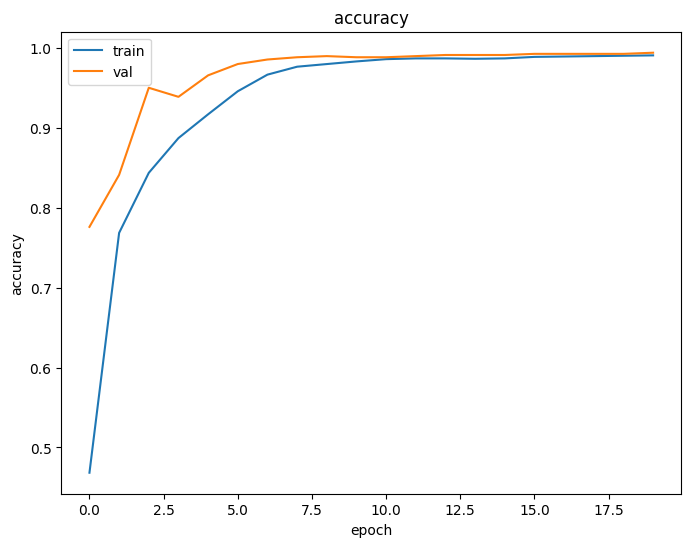

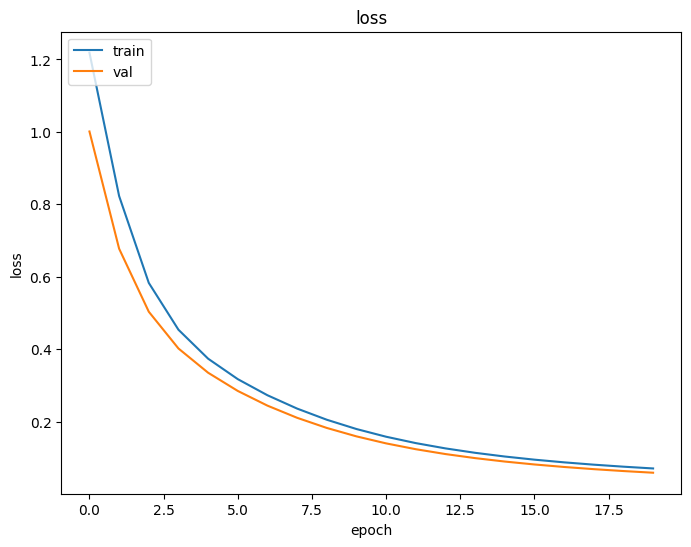

In [ ]:
## TASK: Complete the following function calls
plot_train_val_statistics(history.history['accuracy'], history.history['val_accuracy'], 'accuracy')
plot_train_val_statistics(history.history['loss'], history.history['val_loss'], 'loss')

In [ ]:
# Results on the test set
performance = model.evaluate(x=inputs_test, y=outputs_test)
print(''.join([f"{name}={value:.05f}  " for name, value in zip(model.metrics_names, performance)]))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.0640 
loss=0.06110  compile_metrics=0.99290  


## Optional task

The dataset folder has two more files that we did not use: circle.csv and cross.csv. These contain accelerometer data when I was drawing a circle and a cross (more like an infinity sign). Can you build a classifier to classify circle vs cross?
Hint: The same model architecture may not work as this is a more complex task.

## Food for thought (not to be solved in this lab)

1. Can you create a class imbalanced training dataset where most data is from the idle state and there is a very small amount of punch and wave. You can do this by selecting a subset of the data from the corresponding files. Now, see the relation with the the validation and test performance with the class unbalance.
> Class imbalance is a common problem in many real world tasks. There are many well-known techniques to adress this too.
2. Change the model architecture (add a convolution layer / change the number of parameters in the existing layers) and see its effect on the train and test accuracy. You'll expect a larger model to overfit the training data, and perform worse on test data.
> Can you find a good architecture which perform well and is small? This is automatically done using methods in Network Architecture Search (NAS). This is an active research field like this [paper](https://proceedings.mlsys.org/paper_files/paper/2021/file/c4d41d9619462c534b7b61d1f772385e-Paper.pdf).


## Confidence of the prediction

One popular way to measure the confidence is to measure the Shannon Entropy of the predicted class probabilities. If the entropy is high (more than one classes are probable), then the model is less confident.

Though a model can built in such a way that it'll produce better confidence measurement. This is an active research field in Machine Learning.

In [ ]:
from scipy.stats import entropy

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


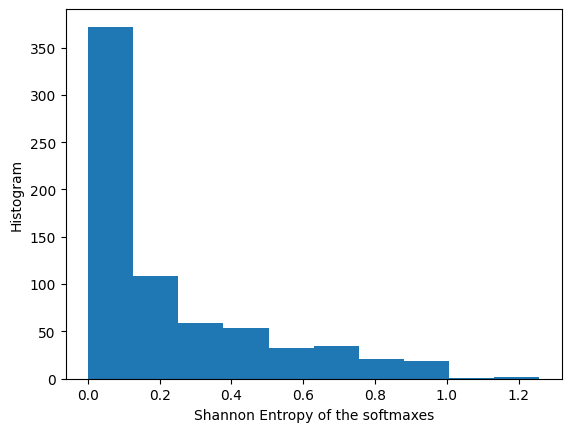

In [ ]:
pred = model.predict(inputs_test)
H = entropy(pred, base=2, axis=1)
plt.hist(H, bins=10)
plt.xlabel("Shannon Entropy of the softmaxes")
plt.ylabel("Histogram")
plt.show()

## Convert the Trained Model to Tensor Flow Lite

Here we use a Tensflow provided model compression method. However, this is an active field of research and if you are interested, feel free to explore model compression methods.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model_quantized.tflite", "wb").write(tflite_model)

Saved artifact at '/tmp/tmpqpfrx9i9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 3), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132046112911824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132046112913168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132046107706384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132046107705616: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved artifact at '/tmp/tmpti4s303s'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 3), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132046112911824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132046112913168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132046107706384: TensorSpec(shape=()

2988

## Encode the Model in an Arduino Header File
The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model_quantized.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 18,460 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


## Food for thought (not to be solved in this lab): [more HAR use cases - perhaps dissertation]

1. Including other activities: Say we want to build a whiteboard marker which can 'read' what is written and transmit to a computer. The marker will include an Arduino. How can you build an activity recognizer that will recognize the letters and numbers while they are written?
2. Perhaps our walking style changes based on our mental and physical state: walking nervously to an interview, walking after a party or brisking in excitement! Suppose, we embed an arduino board inside shoes so that it can sense the accelerarometer signal. Can you identify mood from such a signal?

The purpose of this is to show you that there is a wide variety of topics to explore. Arduino has many other sensors as well ranging from microphone to gyroscope. Feel free to explore and come up with cool ideas!

# [Arduino Nano 33 BLE](https://store.arduino.cc/products/arduino-nano-33-ble)

## Setting up and Reading Accelerometer values

We have looked at reading accelerometer data from the Arduino 33 Nano BLE in lab 1.  This section is a refresh of that material.

1. [Download](https://support.arduino.cc/hc/en-us/articles/360019833020-Download-and-install-Arduino-IDE), install and open Arduino IDE (use the latest version). The detailed information for this set up is there in your labsheet for Arduino Nano 33 BLE and Flutter.
Test the installation by running the Blink example as done [here](https://docs.arduino.cc/learn/starting-guide/the-arduino-software-ide/) (follow the 2.x version).
2. Go to Tools->Manage LIbraries and search for "Arduino_LSM9DS1". It should produce one library. Install it.
3. Open the example from File->Example->Arduino_LSM9DS1->SimpleAceelerometer (it should appear at the end of the long list of examples. It should open an ino file.
4. Run the the SimpleAceelerometer application (similar way as the Blink example). Open the Tools -> Serial Monitor to see the x, y, and z acceleration values. Move the board (while connected) to see changes in the values. These values are continuously plotted in Tools->Serial Plotter.
5. The datasets used previous week were collected by saving x, y, and z values from the serial output. You can optionally try to record datasets; Simply redirect the serial output (use the port that you found in step 1) to a file. E.g., in mac:

> cat /dev/cu.usbmodem11101 > <file_name\>



## Setup [TFLite](https://www.tensorflow.org/lite) and use the above model you trained.

1. Download and install TFLite in your computer by following the instructions [here](https://github.com/tensorflow/tflite-micro-arduino-examples). Verify the installation by running the hello_world example. If you do not have git installed, instead of git clone you can download the zip of the code and copy it insde the libraries (Code->Download zip). Compilation may take long, be patient.
2. Now run the IMU_classifier.ino sketch that you downloaded previously from this [link](https://drive.google.com/drive/folders/1tHONz7qgeFB87TVK2b-A18dbe8WRgV0g?usp=sharing). Remember to have the model.h in the same folder. Open the Tools->Serial Monitor, you should see class probabilities. Do the punches, wave, and idle to see if the classes are recognized correctly.
3. Now replace the model.h you have created and downloaded previously in the same folder and re-run the sketch.


Optional tasks:
1. Why there is a delay between you performing an activity and the class probabilitites changing? How can you reduce the delay?
2. Measure the memory usage in Arduino. Record and show how does it vary if we reduce the frequency of the model usage? Can you run the model only when there is a chance of an activity (E.g., the idle is not an interesting state)?